# Simulation on Orthogonal Estimation - ex4.8.1 Experiment with this notebook, sourced from:
### Chernozhukov, V. & Hansen, C. & Kallus, N. & Spindler, M. & Syrgkanis, V. (2024): Applied Causal Inference Powered by ML and AI. CausalML-book.org; arXiv:2403.02467. 
### See webpage https://causalml-book.org/
note. I've also stripped out parallel functions since I'm trying to keep my environment rather lean.

We compare the performance of the naive and orthogonal methods in a computational experiment where
$p=n=100$, $\beta_j = 1/j^2$, $(\gamma_{DW})_j = 1/j^2$ and $$Y = 1 \cdot D + \beta' W + \epsilon_Y$$

where $W \sim N(0,I)$, $\epsilon_Y \sim N(0,1)$, and $$D = \gamma'_{DW} W + \tilde{D}$$ where $\tilde{D} \sim N(0,1)/4$.

The true treatment effect here is 1. From the plots produced in this notebook (estimate minus ground truth), we show that the naive single-selection estimator is heavily biased (lack of Neyman orthogonality in its estimation strategy), while the orthogonal estimator based on partialling out, is approximately unbiased and Gaussian.

In [4]:
import hdmpy
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [21]:
# Initialize constants
B = 10000  # Number of iterations
n = 100  # Sample size
p = 100  # Number of features

# Sim Parameters
mean = 0
sd = 1


def exp(it):
    np.random.seed(it)
    # Generate parameters:
    gamma = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)
    beta = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)

    # Generate covariates / random data
    X = np.random.normal(mean, sd, n * p).reshape(n, p)
    D = (X @ gamma) + np.random.normal(mean, sd, n).reshape(n, 1) / 4

    # Generate Y using DGP
    Y = D + (X @ beta) + np.random.normal(mean, sd, n).reshape(n, 1)

    # Single selection method using rlasso
    """ The single selection method uses one big Lasso selection procedure to pick covariates, and then applies an OLS based on that selection, this is not Neyman Orthogonal and leads to poor convergence with slowly shrinking bias """
    r_lasso_estimation = hdmpy.rlasso(np.concatenate((D, X), axis=1), Y, post=True)
    coef_array = r_lasso_estimation.est['coefficients'].iloc[2:, :].to_numpy()
    SX_IDs = np.where(coef_array != 0)[0]

    # Check if any X coefficients are selected
    if sum(SX_IDs) == 0:
        # If no X coefficients are selected, regress Y on D only
        Naive = sm.OLS(Y, sm.add_constant(D)).fit().params[1]
    else:
        # If X coefficients are selected, regress Y on selected X and D
        X_D = np.concatenate((D, X[:, SX_IDs]), axis=1)
        Naive = sm.OLS(Y, sm.add_constant(X_D)).fit().params[1]

    # Double Lasso Partialling Out
    """ In double Lasso, first we select covariates by Lasso on Y, and keep the residuals from that selection Yhat"""
    fitY = hdmpy.rlasso(X, Y, post=True)
    resY = fitY.est['residuals']
    resYalt = hdmpy.rlasso(X, Y, post=False).est['residuals'] # Tested addition, Get the residual of a non post-lasso fit as well

    """ Then we select covariates for D by Lasso of X on D, and keep these residuals Dhat"""
    fitD = hdmpy.rlasso(X, D, post=True)
    resD = fitD.est['residuals']
    resDalt = hdmpy.rlasso(X, D, post=False).est['residuals'] # Tested addition, Get the residual of a non post-lasso fit as well

    """ Finally we regress the Yhat residuals by Dhat residuals. This works because of partialling out. There is no magic for why this version works where the above one fails, this method just happens to be Neyman orthogonal where the above is not, so we get a faster convergence with much more rapidly shrinking bias """
    Orthogonal = sm.OLS(resY, sm.add_constant(resD)).fit().params[1]
    Orthogonal_alt = sm.OLS(resYalt, sm.add_constant(resDalt)).fit().params[1] # Tested addition, uses standard lasso instead of postlasso in neyman orthog estimator, I think it could introduce a bias to tune up the magnitude of D, since the other factors will tend to underexplain under standard Lasso

    return Naive, Orthogonal, Orthogonal_alt


results = [exp(it) for it in range(B)]

Naive, Orthogonal, Orthogonal_alt = zip(*results)
Naive, Orthogonal, Orthogonal_alt = np.array(Naive), np.array(Orthogonal), np.array(Orthogonal_alt)

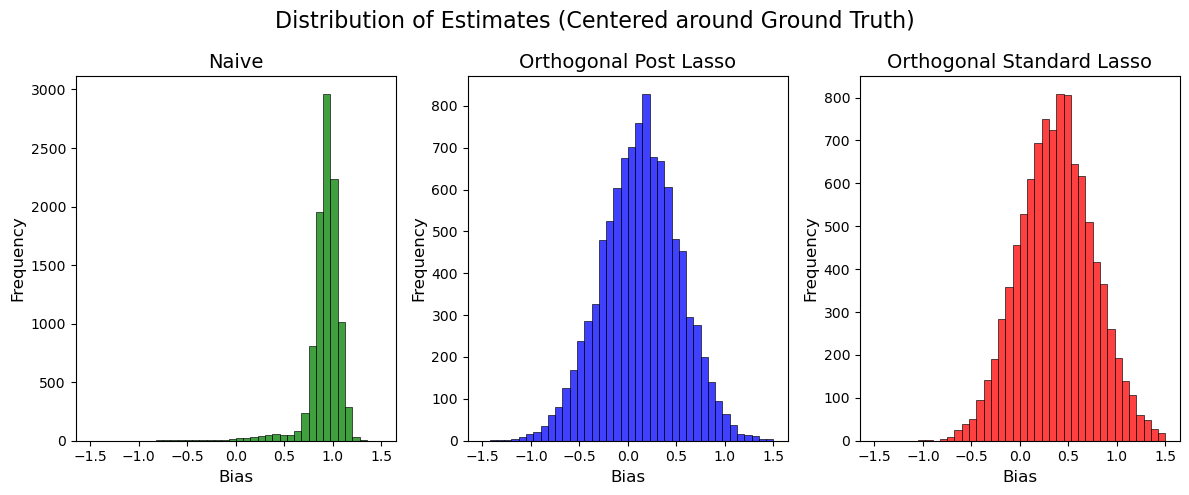

In [22]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot a histogram for the 'Naive' estimates vector
sns.histplot(Naive - 1, bins=40, kde=False, color='green', ax=axes[0], binrange = (-1.5,1.5)) # I changed the binranges and bin count for granularity, so that all of the fits share the same bins
axes[0].set_title('Naive', fontsize=14)
axes[0].set_xlabel('Bias', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Plot a histogram for the 'Orthogonal' estimates vector
sns.histplot(Orthogonal - 1, bins=40, kde=False, color='blue', ax=axes[1], binrange = (-1.5,1.5))
axes[1].set_title('Orthogonal Post Lasso', fontsize=14)
axes[1].set_xlabel('Bias', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Plot a histogram for the Post Lasso 'Orthogonal' estimates vector
sns.histplot(Orthogonal_alt - 1, bins=40, kde=False, color='red', ax=axes[2], binrange = (-1.5,1.5))
axes[2].set_title('Orthogonal Standard Lasso', fontsize=14)
axes[2].set_xlabel('Bias', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)

# Add a title to the entire figure
fig.suptitle('Distribution of Estimates (Centered around Ground Truth)', fontsize=16)

# Display the histograms side by side
plt.tight_layout()
plt.show()

Not my work: As we can see from the above bias plots (estimates minus the ground truth effect of 1), the double lasso procedure concentrates around zero whereas the naive estimator does not.


My Reflections: As expected the standard Lasso performs worse than the post lasso. Since the base value for the fitted param is 1, we are seeing as I expected an increase in magnitude as well, so it seems like for this problem my intution was correct. The quality of fit for the Neyman orthogonal approach is frankly very impressive, even with the fact that this is a constructed problem in mind. This is absolutely a technique I will be remembering for the future. If I come back and work any more in this file I think it'll be in adding the "Double selection", for a third point of comparison, I think depending on the problem both debiased approaches have pros and cons. The Double Lasso approach gives you a nice idea of X affecting D in one way and Y in another, with param estimates for each. But double selection Lasso is a bit more flexible, and it seems fair to think that regressing on the union of controls can show interesting properties.

Finally "Debiased Lasso" is a third procedure, but given that it relies on a special moment equation there's not quite as clear of an intution around how it will behave in my eyes. Given that it's seen use in econometrics it's worth digging into a bit more..